In [4]:
import numpy as np
import math
import tensorflow as tf
from tensorflow.python.framework import ops
import h5py
import time
import matplotlib.pyplot as plt

%matplotlib inline

## <u>Problem Statement:
We are given pictures of hand signs taken from **SIGNS Dataset** where each picture shows a hand sign denoting a number from 0-5.
- **Training set**: pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (180 pictures per number).
- **Test set**: pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (20 pictures per number).


## <u>Preprocessing Step</u>
### First we need to load the data


In [5]:
'''
Loads the data from the data set file
Arguments:
    nil
returns:
    train_X:(numpy array) contains the training features
    train_y:(numpy array) contains the correct labels for the training examples
    test_X:(numpy array) contains the test features
    test_y:(numpy array) contains the correct labels for the test examples
'''
def loadData():
    
    # load the train file
    train_data = h5py.File('datasets/train_signs.h5', "r")
    # load the training features 
    train_X = np.array(train_data['train_set_x'][:])
    # load the correct labels for training set
    train_y = np.array(train_data['train_set_y'][:])
    
    # load the test file
    test_data = h5py.File('datasets/test_signs.h5', "r")
    # load the test features 
    test_X = np.array(test_data['test_set_x'][:])
    # load the correct labels for test set
    test_y = np.array(test_data['test_set_y'][:])
    
    return train_X, train_y, test_X, test_y

In [6]:
#load the data
train_X, train_y, test_X, test_y = loadData()

#### First let us check the dimensions of the loaded data variables

In [7]:
print('Training set shape:'+ str(train_X.shape))
print('Training set shape:'+ str(train_y.shape))
print('Test set shape:'+ str(test_X.shape))
print('Test set shape:'+ str(test_y.shape))

Training set shape:(1080, 64, 64, 3)
Training set shape:(1080,)
Test set shape:(120, 64, 64, 3)
Test set shape:(120,)


#### Reshape the required variables


In [8]:
train_y = np.reshape(train_y, (train_y.shape[0],1))
test_y = np.reshape(test_y, (test_y.shape[0],1))

#### Visualise the input data


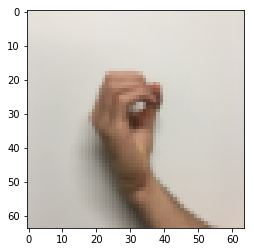

In [9]:
rand_index = np.random.randint(0,train_X.shape[0])
plt.imshow(np.squeeze(train_X[rand_index]))

### Next step is to Normalize the features and flatten the pixel values in a vector instead of having them in a 3 channel matrix.
For images dividing the pixel values by 255 is enough to normalize the values.
<br> For flattening the input features from (m, height, width, 3) to (height X width X 3, m) we will use **reshape() from numpy.** 
<br>Also correct labels vector neeeds to be converted into one hot matrix.

In [10]:
# Normalize the features
train_X = train_X/255
test_X = test_X/255

In [11]:
# Unroll/Flatten the feature vectors
train_X = train_X.reshape(train_X.shape[0], -1).T
test_X = test_X.reshape(test_X.shape[0], -1).T

# converting correct labels matrix to one hot matrix
train_y = np.eye(6)[train_y.reshape(-1)].T
test_y = np.eye(6)[test_y.reshape(-1)].T

print('Training set feature shape:'+ str(train_X.shape))
print('Training set labels shape:'+ str(train_y.shape))
print('Test set features shape:'+ str(test_X.shape))
print('Test set labels shape:'+ str(test_y.shape))

Training set feature shape:(12288, 1080)
Training set labels shape:(6, 1080)
Test set features shape:(12288, 120)
Test set labels shape:(6, 120)


## <u>Neural Network Architecture
<br>Input layer: 12288 features
<br>No. of Hidden Layers: 4
<br>No. of units in hidden layer: 25, 12, 10, 8
<br>Output Layer units: 6 (for 6 classes)

**Model:**
<br>input --> Linear --> ReLU --> Linear -->ReLU -->Linear -->Softmax(output)

In tensorflow we define blocks for the computational graph and in the end run the data through the computational graph.
<br>So for coding in tensforflow we need not worry about finding the gradients for backpropagation as all the things are systematically coded in computaional blocks, tensorflow can find the gradients for us.<br>
<br><u>**Steps:**</u>
<br>1) Create tensors 
<br>2) Define the operations to do with the tensors
<br>3) initialize the variables
<br>4) start and run the session to run the graph model

In [21]:
def createPlaceholders(n_x, n_y):
    # create tf placeholders required for computational graph
    X = tf.placeholder(shape = [n_x, None], dtype = 'float')
    y = tf.placeholder(shape = [n_y, None], dtype = 'float')
  
    return X, y

### First we will initialize the weights for different layers
We will be using Xavier Initialization.


In [19]:
def initializeParam(num_layers, num_units):
    # for storing the parameters for the neural network mainly weight and bias values
    parameters = {}
    
    for l in range(num_layers):
        parameters['W' + str(l+1)] = tf.get_variable(name = 'W' + str(l+1), shape = [num_units[l+1],num_units[l]],
                                                        initializer = tf.contrib.layers.xavier_initializer())
        parameters['b' + str(l+1)] = tf.get_variable(name = 'b' + str(l+1), shape = [num_units[l+1],1],
                                                        initializer = tf.zeros_initializer())
            
    return parameters    

### <u>Forward propagation


In [27]:
def forwardPropagate(num_layers, num_units, X, parameters):
    # make the initial activation equal to the input features
    A = X
    # find the linear output and activation output for each layer
    for l in range(num_layers - 1):
        # find the linear output for layer l
        Z = tf.add( tf.matmul(parameters['W' + str(l+1)], A), parameters['b' + str(l+1)])
        A = tf.nn.relu(Z)
    # linear output for the final layer
    Z = tf.add( tf.matmul(parameters['W' + str(num_layers)], A), parameters['b' + str(num_layers)])
    return Z

### <u>Cost function

In [23]:
def computeCost(Z, y):
    # we will do softmax in the output layer and then find the cost
    # for tensorflow we need to give the arg. in (m, n) format
    softmax_output = tf.transpose(Z)
    corr_labels = tf.transpose(y)
    
    return tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits = softmax_output, labels = corr_labels))

In [16]:
'''
Makes shuffled minibatches from the examples
Arguments:
    X: (tensorflow array) input features
    y: correct output labels for examples
    minibatch_size: (int) size of each minibatch
returns:
    mini_batches: Returns a list containing tuple pairs of feature vectors and correct output labels
'''
def getRandomMiniBatches(X, y, minibatch_size = 64):
    # total training examples
    m = X.shape[1]
    # we will store the mini batches as tuple pair in a list
    mini_batches = []
    
    ## First we need to shuffle the training examples
    permutation_list = list(np.random.permutation(m))
    shuffled_X = X[:, permutation_list]
    shuffled_y = y[:, permutation_list]
    
    # find the total no. of mini batches that can be formed from the training examples
    num_minibatches = math.floor(m/minibatch_size) 
    
    # now partition the original training set into mini batches
    # we make mini batches till the time complete mini batches can be made
    for i in range(num_minibatches):
        minibatch_X = X[:, i*minibatch_size: i*minibatch_size + minibatch_size]
        minibatch_y = y[:, i*minibatch_size: i*minibatch_size + minibatch_size]
        
        minibatch = (minibatch_X, minibatch_y)
        mini_batches.append(minibatch)
        
    # if number of minibatches that can be made is not a multiple of 'm'
    if m % num_minibatches != 0:
        minibatch_X = X[:, i*minibatch_size: m]
        minibatch_y = y[:, i*minibatch_size: m]
        
        minibatch = (minibatch_X, minibatch_y)
        mini_batches.append(minibatch)
        
    return mini_batches

### <u>Backward Propagation and Optimization
Tensorflow takes care of finding the gradients so our job is to provide it with the cost function and telling which optimizer to use.

In [49]:
def nnModel(num_layers, layer_units, X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 64):
    # allows the graph to run without overwriting the graph
    ops.reset_default_graph()
    
    # no. of features and training examples 
    (n_x, m) = X_train.shape
    # no. of minibatches
    num_minibatches = math.floor(m/minibatch_size)
    # no. of units in output layer
    n_y = Y_train.shape[0]
    
    # for stroing the costs 
    costs = []
    
    ## Set the computational graph in place 
    # create placeholders
    X, y = createPlaceholders(n_x, n_y)
    
    # initialize the parameters
    parameters = initializeParam(num_layers, layer_units)
    
    # do forward propagation
    Z = forwardPropagate(num_layers, layer_units, X, parameters)
    
    # for computing the cost
    cost = computeCost(Z, y)
    
    # setting the optimization technique
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # initilaze all the tf variables
    init = tf.global_variables_initializer()
    
    # start a tf session and start training the neural network
    with tf.Session() as sess:
        # initilaize variables
        sess.run(init)
       
        for epoch in range(num_epochs):
            epoch_cost = 0
            # get the shuffled mini batches
            minibatches = getRandomMiniBatches(X_train, Y_train, minibatch_size)
            
            # start with each mini batch
            for minibatch in minibatches:
                # curr mini batch
                (minibatch_X, minibatch_y) = minibatch
                (minibatch_cost, _) = sess.run([cost, optimizer], feed_dict = {X:minibatch_X, y:minibatch_y})
                
                epoch_cost += minibatch_cost
                
            epoch_cost = epoch_cost/num_minibatches
            
            # printing the cost to see progress
            if epoch % 50 == 0:
                print('Cost for epoch %i: %f' % (epoch, epoch_cost))
           
            # storing the epoch cost for plotting 
            if epoch % 5 == 0:
                costs.append(epoch_cost)

        print ("Training done")    
        
        # save and return the parameters so that it can be used again
        parameters = sess.run(parameters)
        
        return parameters, costs

### Now time to do training on the neural network

In [64]:
# for calculating the time taken for computation
start = time.clock()
num_layers = 5
layer_units = [train_X.shape[0], 25, 12, 10, 8, 6]

learning_rate = 0.0001,
minibatch_size = 64

# training the model
parameters, costs = nnModel(num_layers, layer_units, train_X, train_y, test_X, test_y, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 64)
print('Time taken: ' + str((time.clock() - start)/60) + ' minutes')

Cost for epoch 0: 1.945247
Cost for epoch 50: 1.665779
Cost for epoch 100: 1.360991
Cost for epoch 150: 1.158073
Cost for epoch 200: 1.018115
Cost for epoch 250: 0.897654
Cost for epoch 300: 0.808588
Cost for epoch 350: 0.734049
Cost for epoch 400: 0.672968
Cost for epoch 450: 0.620432
Cost for epoch 500: 0.575863
Cost for epoch 550: 0.539022
Cost for epoch 600: 0.504949
Cost for epoch 650: 0.475009
Cost for epoch 700: 0.454618
Cost for epoch 750: 0.457055
Cost for epoch 800: 0.486262
Cost for epoch 850: 0.449228
Cost for epoch 900: 0.417518
Cost for epoch 950: 0.375137
Cost for epoch 1000: 0.351158
Cost for epoch 1050: 0.335805
Cost for epoch 1100: 0.327473
Cost for epoch 1150: 0.299647
Cost for epoch 1200: 0.289063
Cost for epoch 1250: 0.285872
Cost for epoch 1300: 0.292720
Cost for epoch 1350: 0.325733
Cost for epoch 1400: 0.270084
Cost for epoch 1450: 0.273905
Training done
Time taken: 9.43382671858394 minutes


#### For plotting  cost vs epoch graph to see how the cost changes

In [59]:
'''
Plots cost vs Interation
Arguments:
    costs: list of cost computed during every 5th epoch
    learning_rate: learning rate of the optimization step
returns:
    nil
'''
def plotCost(costs, learning_rate):
    # plot the graph for cost changing with iterations
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

#### For calculating the accuracy of the Model

In [60]:
'''
Calculates the accuracy on training and test sets
Arguments:
    X_train: training features fro m examples
    Y_train: correct output labels for training examples
    X_test: input features for test examples 
    Y_test:correct otuput labels for examples
    num_layers: no. of layers
    layer_units: list containing the no. of units in each layer
    parameters: trained parameter values for the neural network includes weight and bias values
returns:
    nil
'''
def calculateAccuracy( X_train, Y_train, X_test, Y_test, num_layers, layer_units, parameters ):
    # no. of features
    n_x = X_train.shape[0]
    n_y = 6
    
    # placeholder for input features
    X = tf.placeholder("float", [n_x, None])
    Y = tf.placeholder("float", [n_y,None])
    
    # for storing the tf converted parameters
    tf_param = {}
    
    # convert the parameters to tf 
    for l in range(num_layers):
            tf_param['W' + str(l+1)] = tf.convert_to_tensor(parameters['W' + str(l+1)])
            tf_param['b' + str(l+1)] = tf.convert_to_tensor(parameters['b' + str(l+1)])
    
    # take the output from trained NN by doing forward propagation
    Z3 = forwardPropagate(num_layers, layer_units, X, tf_param)
    
    # Calculate the correct predictions
    corr_predictions = tf.equal(tf.argmax(Z3), tf.argmax(Y))

    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(corr_predictions, "float"))
    with tf.Session() as sess:
        print ("Accuracy on Training set:", accuracy.eval({X: X_train, Y: Y_train})*100)
        print ("Accuracy on Test set:", accuracy.eval({X: X_test, Y: Y_test})*100)

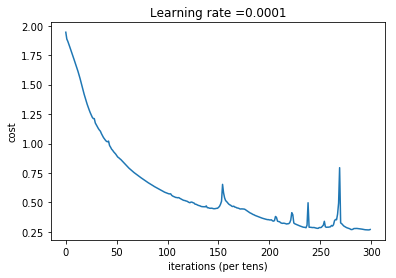

Accuracy on Training set: 93.0555582047
Accuracy on Test set: 69.1666662693


In [65]:
learning_rate = 0.0001
plotCost(costs, learning_rate)
calculateAccuracy( train_X, train_y, test_X, test_y, num_layers, layer_units, parameters )